In [4]:
import numpy as np
from scipy.optimize import root  # For finding fixed point
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from renormalization_hp import *

def rg_map(J_vec, M, b=3):
    """RG transformation T(J) for vector J = [J(1), ..., J(M)]"""
    J_dict = {r+1: J_vec[r] for r in range(M)}  # 1-indexed
    J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
    J_prime_vec = []
    for r in range(1, M+1):
        start = b * r + 1  # Your code uses 3*r +1
        Jp = compute_J_prime_func(start, J_func)
        J_prime_vec.append(Jp)
    return np.array([float(j) for j in J_prime_vec])  # Convert mpmath to float for numpy

def find_fixed_point(n, M=5, initial_guess=None, max_k=1000):
    """Solve J* = T(J*) using your critical J_c as guess"""
    J_c = float(find_J_c(n, max_k=max_k))  # From your code
    rs = np.arange(1, M+1)
    if initial_guess is None:
        initial_guess = J_c / rs**n  # Power-law critical as starting point
    def residual(J_vec):
        return rg_map(J_vec, M) - J_vec
    sol = root(residual, initial_guess, method='lm')  # Levenberg-Marquardt or others
    if sol.success:
        return sol.x
    else:
        raise ValueError("Fixed point not found")

def compute_jacobian(J_star, M, epsilon=1e-6):
    """Numerical Jacobian M at J_star"""
    jac = np.zeros((M, M))
    T_base = rg_map(J_star, M)
    for s in range(M):
        J_pert = J_star.copy()
        J_pert[s] += epsilon
        T_pert = rg_map(J_pert, M)
        jac[:, s] = (T_pert - T_base) / epsilon
    return jac

Eigenvalues: [np.float64(0.2500000000004219), np.float64(-1.6071211827594509e-34), np.float64(0.0), np.float64(0.0), np.float64(0.0)]
Scaling dimensions y_i: [np.float64(-1.2618595071413787), np.float64(-70.82885333725207), 0, 0, 0]


In [ ]:
# Example usage for n=1.5, M=5
n = 1.1
J_star = find_fixed_point(n, M=5)
M_matrix = compute_jacobian(J_star, M=5)
eigenvalues, _ = np.linalg.eig(M_matrix)
eigenvalues = sorted(eigenvalues, key=abs, reverse=True)  # Largest first

b = 3  # Scale factor
ys = np.log(eigenvalues[0]) / np.log(b)

nu = 1/y # correlation-length critical exponent
alpha = 2 - 1/y # specific heat critical exponent

n=0.80, J_c=0.033545, λ_t=0.250000, ν=-0.792481, α=2.792481
n=0.93, J_c=0.103907, λ_t=0.250000, ν=-0.792481, α=2.792481
n=1.06, J_c=0.173909, λ_t=0.250000, ν=-0.792481, α=2.792481
n=1.20, J_c=0.245890, λ_t=0.250000, ν=-0.792481, α=2.792481
n=1.33, J_c=0.322334, λ_t=0.250000, ν=-0.792481, α=2.792481
n=1.46, J_c=0.406332, λ_t=1.000000, ν=-1585552390.439289, α=1585552392.439289
n=1.59, J_c=0.502541, λ_t=1.000000, ν=-1467947118.767954, α=1467947120.767954
n=1.73, J_c=0.619817, λ_t=1.000000, ν=1068734338.800304, α=-1068734336.800304
n=1.86, J_c=0.782267, λ_t=1.000000, ν=1068734338.800304, α=-1068734336.800304
n=1.99, J_c=1.215140, λ_t=0.250000, ν=-0.792481, α=2.792481


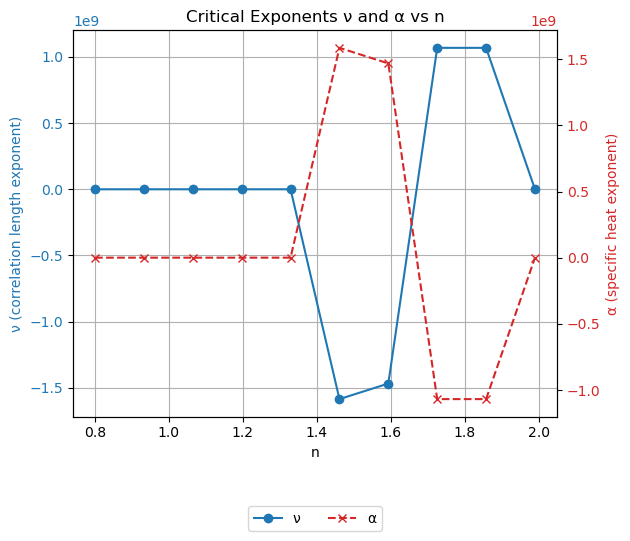

In [13]:
def calculate_exponents(n_values, M=5, b=3):
    """Calculate ν and α for a list of n values"""
    nu_values = []
    alpha_values = []
    for n in n_values:
        try:
            # Find fixed point
            J_star = find_fixed_point(n, M=M)
            # Compute Jacobian
            M_matrix = compute_jacobian(J_star, M=M)
            # Get eigenvalues, take largest by absolute value
            eigenvalues = np.linalg.eigvals(M_matrix)
            eigenvalues = sorted(eigenvalues, key=abs, reverse=True)
            lambda_t = eigenvalues[0]
            # Compute scaling dimension y
            y = np.log(abs(lambda_t)) / np.log(b) if abs(lambda_t) > 0 else 0
            # Compute exponents
            nu = 1 / y if y != 0 else np.inf
            alpha = 2 - 1 / y if y != 0 else -np.inf
            nu_values.append(nu)
            alpha_values.append(alpha)
            print(f"n={n:.2f}, J_c={float(find_J_c(n, max_k=1000)):.6f}, λ_t={lambda_t:.6f}, ν={nu:.6f}, α={alpha:.6f}")
        except Exception as e:
            print(f"n={n:.2f}, error: {e}")
            nu_values.append(np.nan)
            alpha_values.append(np.nan)
    return nu_values, alpha_values

# Generate n values
n_values = np.linspace(0.8, 1.99, 10)
nu_values, alpha_values = calculate_exponents(n_values, M=5, b=3)

# Plot ν and α vs n
fig, ax1 = plt.subplots()

# Plot ν on left y-axis
color_nu = 'tab:blue'
ax1.set_xlabel('n')
ax1.set_ylabel('ν (correlation length exponent)', color=color_nu)
ax1.plot(n_values, nu_values, marker='o', linestyle='-', color=color_nu, label='ν')
ax1.tick_params(axis='y', labelcolor=color_nu)
ax1.grid(True)

# Create second y-axis for α
ax2 = ax1.twinx()
color_alpha = 'tab:red'
ax2.set_ylabel('α (specific heat exponent)', color=color_alpha)
ax2.plot(n_values, alpha_values, marker='x', linestyle='--', color=color_alpha, label='α')
ax2.tick_params(axis='y', labelcolor=color_alpha)

# Title and layout
plt.title('Critical Exponents ν and α vs n')
fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.show()